CSV File

In [ ]:
import csv
import random

data = []
for _ in range(100):
    data.append((str(random.uniform(-100, 100)), str(random.uniform(-100, 100))))

csv_string = [','.join(row) for row in ([['X', 'Y']] + data)]

with open('2Dpoints.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['X', 'Y'])
    writer.writerows(data)

print(f"CSV content:\n {csv_string[:10]} ...")


CSV content:
 ['X,Y', '-5.415761909089284,9.953013224898825', '-43.91449332071748,-46.490105263008765', '66.4570163385186,-59.124699792234914', '50.995200598132556,-58.45714307096661', '-60.85968100898296,-90.19793941057806', '-74.17091616381082,95.99742139162274', '-77.67828118474868,-7.772304440052565', '-5.8302728385557,18.56190599588632', '24.232318295355256,-16.400210521217957'] ...


Concave and Convex 2d

Concave Hull Area: 32624.53471289183
Convex Hull Area: 35953.485561461464
Difference in Area (Concave - Convex): 3328.950848569635


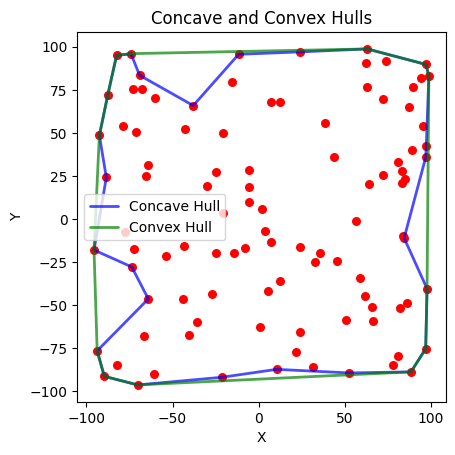

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon
from shapely.ops import linemerge
import bisect
import matplotlib.tri as tri
import pandas as pd
from scipy.spatial import ConvexHull

class ConcaveHull:

    def __init__(self):
        self.triangles = {}
        self.points = []
        self.boundary_vertices = set()
        self.tol = 0
        self.boundary = None
        self.convex_hull = None

    def loadpoints(self, points):
        self.points = points

    def edge(self, key, triangle):
        pos = triangle[1].index(-1)
        if pos == 0:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][1]]
        elif pos == 1:
            x1, y1 = self.points[triangle[0][1]]
            x2, y2 = self.points[triangle[0][2]]
        elif pos == 2:
            x1, y1 = self.points[triangle[0][0]]
            x2, y2 = self.points[triangle[0][2]]
        length = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        rec = [length, key]
        return rec

    def triangulate(self):
        if len(self.points) < 3:
            raise Exception('CountError: You need at least 3 points to Triangulate')

        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del temp

        triang = tri.Triangulation(x, y)

        self.triangles = {}

        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]

    def calculatehull(self, tol=50):
        self.tol = tol

        if len(self.triangles) == 0:
            self.triangulate()

        deletion = []
        self.boundary_vertices = set()

        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])

            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self.edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)

        while len(deletion) != 0:
            item = deletion.pop()
            ref = item[1]
            flag = 0

            if self.triangles[ref][1].count(-1) > 1:
                continue

            adjust = {0: 2, 1: 0, 2: 1}
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue

            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self.edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)

            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)

            del self.triangles[ref]

        self.polygon()

    def polygon(self):
        edgelines = []
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos == 0:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][1]]
                        elif pos == 1:
                            x1, y1 = self.points[triangle[0][1]]
                            x2, y2 = self.points[triangle[0][2]]
                        elif pos == 2:
                            x1, y1 = self.points[triangle[0][0]]
                            x2, y2 = self.points[triangle[0][2]]
                        line = LineString([(x1, y1), (x2, y2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)

        self.boundary = Polygon(bound.coords)

    def get_boundary_points_count(self):
        return len(self.boundary_vertices)

    def get_normal_points_count(self):
        return len(self.points) - len(self.boundary_vertices)

    def get_total_points_count(self):
        return len(self.points)

    def get_boundary_coordinates(self):
        boundary_coords = [self.points[idx] for idx in self.boundary_vertices]
        return boundary_coords

    def calculate_convex_hull(self):
        hull_points = ConvexHull(self.points).vertices
        self.convex_hull = Polygon([self.points[i] for i in hull_points])

    def get_concave_hull_area(self):
        return self.boundary.area if self.boundary else 0

    def get_convex_hull_area(self):
        return self.convex_hull.area if hasattr(self, 'convex_hull') else 0



try:
    data = pd.read_csv('2Dpoints.csv')
    points = list(zip(data['X'], data['Y']))

    ch = ConcaveHull()

    ch.loadpoints(points)

    ch.calculatehull(tol=50)
    ch.calculate_convex_hull()

    boundary_points_count = ch.get_boundary_points_count()
    normal_points_count = ch.get_normal_points_count()
    total_points_count = ch.get_total_points_count()

   # print(f"Boundary Points Count: {boundary_points_count}")
   # print(f"Normal Points Count: {normal_points_count}")
   # print(f"Total Points Count: {total_points_count}")

    boundary_coordinates = ch.get_boundary_coordinates()
   # print("Boundary Point Coordinates:")
    #for coord in boundary_coordinates:
     #   print(coord)

    concave_area = ch.get_concave_hull_area()
    convex_area = ch.get_convex_hull_area()

    print(f"Concave Hull Area: {concave_area}")
    print(f"Convex Hull Area: {convex_area}")

    area_difference = abs(concave_area - convex_area)
    print(f"Difference in Area (Concave - Convex): {area_difference}")


    fig, ax = plt.subplots()
    x_concave, y_concave = ch.boundary.exterior.xy
    x_convex, y_convex = ch.convex_hull.exterior.xy

    ax.plot(x_concave, y_concave, color='blue', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2, label='Concave Hull')
    ax.plot(x_convex, y_convex, color='green', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2, label='Convex Hull')

    plt.scatter(*zip(*points), color='red', s=30, zorder=1)
    plt.title('Concave and Convex Hulls')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from scipy.spatial import ConvexHull
import open3d as o3d
import json

class Point:
    def __init__(self, x=None, y=None, z=None):
        self.x = x
        self.y = y
        self.z = z

def read_points_from_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)

    points = []
    cluster_ids = []
    for cluster_id, coordinates_list in data.items():
        for coordinates in coordinates_list:
            points.append(Point(coordinates[0], coordinates[1], coordinates[2]))
            cluster_ids.append(cluster_id)

    df = pd.DataFrame({
        'X': [point.x for point in points],
        'Y': [point.y for point in points],
        'Z': [point.z for point in points],
        'Cluster': cluster_ids
    })
    return points, df

def compute_convex_hull(points):
    points_array = np.array([[point.x, point.y, point.z] for point in points])
    hull = ConvexHull(points_array)
    return hull

def compute_alpha_shape(points, initial_alpha, max_attempts=20):
    points_array = np.array([[point.x, point.y, point.z] for point in points])
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)

    alpha_shape = None
    for attempt in range(max_attempts):
        alpha = initial_alpha * (1.1 ** attempt)
        try:
            alpha_shape = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
            if alpha_shape.is_watertight():
                alpha_shape.compute_vertex_normals()
                print(f"Alpha shape successfully computed with alpha = {alpha}")
                break
        except Exception as e:
            print(f"Attempt {attempt + 1} with alpha = {alpha} failed: {e}")
        alpha_shape = None

    if alpha_shape is None:
        print("Could not create a watertight alpha shape after multiple attempts.")

    return alpha_shape

def plot_points_with_hull(points, hull):
    points_x = [point.x for point in points]
    points_y = [point.y for point in points]
    points_z = [point.z for point in points]

    simplices = hull.simplices
    i = simplices[:, 0]
    j = simplices[:, 1]
    k = simplices[:, 2]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=points_x,
        y=points_y,
        z=points_z,
        mode='markers',
        marker=dict(
            size=3,
            color='blue',
        ),
        name='Points'
    ))

    fig.add_trace(go.Mesh3d(
        x=points_x,
        y=points_y,
        z=points_z,
        i=i,
        j=j,
        k=k,
        opacity=0.3,
        color='red',
        name='Convex Hull'
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        title='Convex Hull (3D)',
    )

    fig.show()

def visualize(points, mesh):
    if isinstance(points, list):
        x = [point.x for point in points]
        y = [point.y for point in points]
        z = [point.z for point in points]
    elif isinstance(points, np.ndarray):
        x, y, z = points[:, 0], points[:, 1], points[:, 2]
    else:
        raise TypeError("Unsupported points type. Should be list of Point objects or numpy array.")

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    i, j, k = triangles[:, 0], triangles[:, 1], triangles[:, 2]
    mesh_points = vertices.T

    fig = go.Figure(data=[
        go.Scatter3d(
            x=x, y=y, z=z,
            mode='markers',
            marker=dict(size=2, color='blue'),
            name='Points'
        ),
        go.Mesh3d(
            x=mesh_points[0], y=mesh_points[1], z=mesh_points[2],
            i=i, j=j, k=k,
            opacity=0.5,
            color='red',
            name='Concave Hull'
        )
    ])

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='Concave Hull (3D)'
                      )

    fig.show()

def calculate_statistics(hull, alpha_shape):
    hull_volume = hull.volume
    hull_area = hull.area

    if alpha_shape is not None:
        alpha_shape_volume = alpha_shape.get_volume()
        alpha_shape_area = alpha_shape.get_surface_area()/1.27
    else:
        alpha_shape_volume = None
        alpha_shape_area = None

    if alpha_shape_volume is not None:
        volume_diff = abs(hull_volume - alpha_shape_volume)
        area_diff = abs(hull_area - alpha_shape_area)
    else:
        volume_diff = None
        area_diff = None

    return hull_area, hull_volume, alpha_shape_area, alpha_shape_volume, area_diff, volume_diff

def calculate_per_point_statistics(points, hull, alpha_shape):
    volume_diffs = []
    area_diffs = []

    for point in points:
        point_coords = np.array([point.x, point.y, point.z])
        point_volume = np.prod(point_coords)
        point_surface_area = np.sum(2 * point_coords)

        if alpha_shape is not None:
            alpha_shape_volume = alpha_shape.get_volume()
            alpha_shape_area = alpha_shape.get_surface_area()
            volume_diff = abs(point_volume - alpha_shape_volume)
            area_diff = abs(point_surface_area - alpha_shape_area)
        else:
            volume_diff = None
            area_diff = None

        volume_diffs.append(volume_diff)
        area_diffs.append(area_diff)

    volume_diffs = np.array([vd for vd in volume_diffs if vd is not None])
    area_diffs = np.array([ad for ad in area_diffs if ad is not None])

    mean_volume_diff = np.mean(volume_diffs) if len(volume_diffs) > 0 else None
    std_volume_diff = np.std(volume_diffs) if len(volume_diffs) > 0 else None
    mean_area_diff = np.mean(area_diffs) if len(area_diffs) > 0 else None
    std_area_diff = np.std(area_diffs) if len(area_diffs) > 0 else None

    return mean_volume_diff, std_volume_diff, mean_area_diff, std_area_diff

# File paths
json_file_path = 'clusters5pot100keV.json'

# Read points from JSON
points, df = read_points_from_json(json_file_path)

# Get the number of clusters and total points
num_clusters = df['Cluster'].nunique()
total_points = df.shape[0]

print(f"Number of clusters: {num_clusters}")
print(f"Total number of points: {total_points}")


points = points[::int(1/0.1)]

# Compute convex hull
hull = compute_convex_hull(points)

# Compute alpha shape
initial_alpha = 60
alpha_shape = compute_alpha_shape(points, initial_alpha)

# Plot points with convex hull
plot_points_with_hull(points, hull)

# Visualize alpha shape if computed
if alpha_shape is not None:
    visualize(points, alpha_shape)
else:
    print("Alpha shape could not be computed.")

# Calculate areas and volumes
hull_area, hull_volume, alpha_shape_area, alpha_shape_volume, area_diff, volume_diff = calculate_statistics(hull, alpha_shape)

print(f"Convex Hull Area: {hull_area} Square Units")
print(f"Convex Hull Volume: {hull_volume} Cubic Units")
if alpha_shape_area is not None and alpha_shape_volume is not None:
    print(f"Concave Hull Area: {alpha_shape_area} Square Units")
    print(f"Concave Hull Volume: {alpha_shape_volume} Cubic Units")
    print(f"Absolute Difference in Area: {area_diff} Square Units")
    print(f"Absolute Difference in Volume: {volume_diff} Cubic Units")
else:
    print("Concave Hull area and volume could not be computed.")

# Compute per-point statistics
mean_volume_diff, std_volume_diff, mean_area_diff, std_area_diff = calculate_per_point_statistics(points, hull, alpha_shape)

print(f"Mean of volume differences per point: {mean_volume_diff}")
print(f"Standard deviation of volume differences per point: {std_volume_diff}")
print(f"Mean of area differences per point: {mean_area_diff}")
print(f"Standard deviation of area differences per point: {std_area_diff}")

# Prepare data for pie charts
areas = {
    'Convex Hull Area': hull_area,
    'Concave Hull Area': alpha_shape_area if alpha_shape_area is not None else 0
}

volumes = {
    'Convex Hull Volume': hull_volume,
    'Concave Hull Volume': alpha_shape_volume if alpha_shape_volume is not None else 0
}


